In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %reload_ext autoreload

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
import homography, rectification, filters, my_types, utils

# input files

In [5]:
DATA = Path("data")
OUTDIR = Path("output")

In [6]:
name  = "plush"
im1_name = DATA / (name + "1.jpg")
im2_name = DATA / (name + "2.jpg")

In [7]:
plane_name = DATA / (name + "_plane.pkl")

warp1_name = DATA / (im1_name.stem + "_w.jpg")
warp2_name = DATA / (im2_name.stem + "_w.jpg")

pts1_name = DATA / (im1_name.stem + "_w.pkl")
pts2_name = DATA / (im2_name.stem + "_w.pkl")

In [8]:
mosaic_name = OUTDIR / (name + "_mosaic.jpg")

# Pick Correspondences

In [9]:
im1 = utils.read_img(im1_name)
im2 = utils.read_img(im2_name)

In [10]:
try:
    %matplotlib inline
    im1_pts = utils.load_points(im1_name)
    im2_pts = utils.load_points(im2_name)
except:
    %matplotlib tk
    im1_pts = utils.pick_points(im1_name, 4)
    im2_pts = utils.pick_points(im2_name, 4)
    utils.save_points(im1_pts, im1_name)
    utils.save_points(im2_pts, im2_name)

In [11]:
im1_pts = im1_pts[:4]
im2_pts = im2_pts[:4]

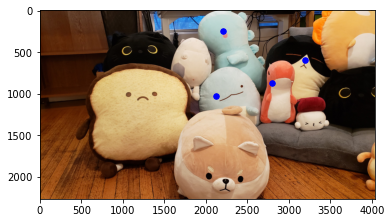

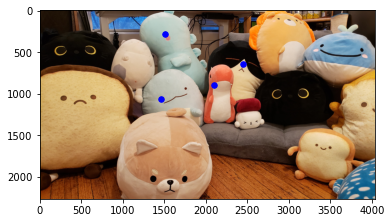

In [12]:
%matplotlib inline
utils.plot_pts(im1, im1_pts)
utils.plot_pts(im2, im2_pts)

# Image Rectification

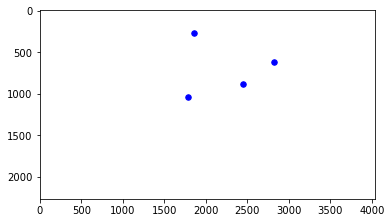

In [13]:
try:
    plane_pts = utils.load_points(plane_name)
except:
    %matplotlib tk
    plane_pts = utils.pick_points(im1, 4)
    utils.save_points(plane_pts, plane_name)

%matplotlib inline
canvas = np.ones_like(im1)
utils.plot_pts(canvas, plane_pts)

In [165]:
h_matrix1 = homography.homo_matrix(im1_pts, plane_pts)
h_matrix1

array([[ 1.26262915e+00,  8.54015338e-02, -6.99588602e+02],
       [ 3.88081249e-02,  1.16812831e+00, -7.48687882e+01],
       [ 5.59396866e-05,  3.61017605e-05,  1.00000000e+00]])

In [166]:
import itertools
h, w, c = im1.shape
x, y = w, h
print(im1.shape)
corners = [
    [0, 0],
    [0, y - 1],
    [x - 1, y - 1],
    [x - 1, 0],
]  # in this order for polygon
corners = np.array(corners)
print(corners)

(2268, 4032, 3)
[[   0    0]
 [   0 2267]
 [4031 2267]
 [4031    0]]


In [167]:
corners_3D = np.array([[x, y, 1] for x, y in corners])
corners_3D.T

array([[   0,    0, 4031, 4031],
       [   0, 2267, 2267,    0],
       [   1,    1,    1,    1]])

In [168]:
target_corners = h_matrix1 @ corners_3D.T
target_corners /= target_corners[2]
target_corners.T[:, :2]

array([[-699.58860245,  -74.86878821],
       [-467.70508262, 2378.60654012],
       [3506.11952947, 2087.997695  ],
       [3582.28886696,   66.55833331]])

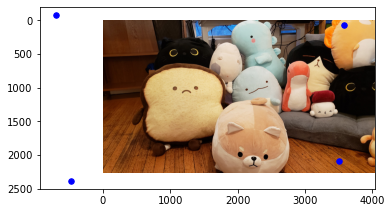

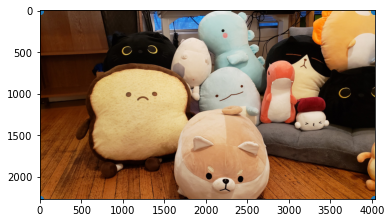

In [169]:
utils.plot_pts(im1, target_corners.T[:, :2])
plt.imshow(im1)
plt.scatter(corners[:, 0], corners[:, 1])

In [170]:
target_corners = np.round(target_corners).astype(np.int64)
target_corners

array([[-700, -468, 3506, 3582],
       [ -75, 2379, 2088,   67],
       [   1,    1,    1,    1]])

In [171]:
target_x = target_corners[0, :]
target_x

array([-700, -468, 3506, 3582])

In [172]:
target_y = target_corners[1, :]
target_y

array([ -75, 2379, 2088,   67])

In [173]:
import skimage as sk
warp_h, warp_w = abs(target_y.max() - target_y.min()), abs(target_x.max() - target_x.min())
warp_h, warp_w = int(np.ceil(warp_h)), int(np.ceil(warp_w))

target_rr, target_cc = sk.draw.polygon(
    r=target_y - target_y.min(), c=target_x-target_x.min(), shape=(warp_h, warp_w)
)

warped = np.zeros((warp_h, warp_w, 3))
print(warped.shape)

(2454, 4282, 3)


In [174]:
target_y - target_y.min()

array([   0, 2454, 2163,  142])

In [175]:
target_x - target_x.min()

array([   0,  232, 4206, 4282])

In [176]:
target_x.max() - target_x.min()

4282

In [177]:
target_cc

array([  1,   2,   3, ..., 243, 244, 245])

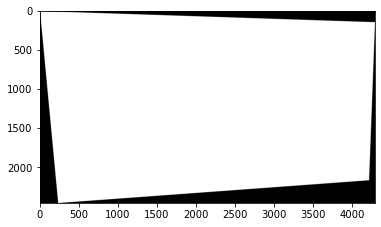

In [178]:
# target_rr -= target_rr.min()
# target_cc -= target_cc.min()
warped[target_rr, target_cc] = 1
plt.imshow(warped)

In [212]:
warp1, shift_pts1 = homography.inverse_warp(im1, h_matrix1)
warp_pts1 = homography.warp_pts(im1_pts, h_matrix1, shift_pts1)

====target====
(2454, 4282, 3)
1 1
2453 4281
-74 -699
2378 3581
=====src=====
(2268, 4032, 3)
-0.30345586917690687 -0.09307797059105663
4030.8397019937606 2267.3443161673663
=====interpolate=====


In [213]:
warp1.shape

(2454, 4282, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


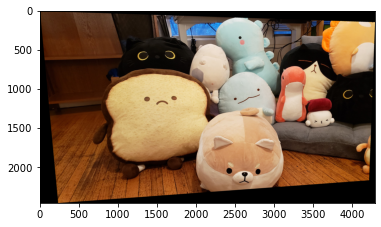

In [214]:
plt.imshow(warp1)

In [14]:
try:
    warp1 = utils.read_img(warp1_name)
    warp_pts1 = utils.load_points(pts1_name)

except:
    print("warping...")

    h_matrix1 = homography.homo_matrix(im1_pts, plane_pts)
    warp1, shift_pts1 = homography.inverse_warp(im1, h_matrix1)
    warp_pts1 = homography.warp_pts(im1_pts, h_matrix1, shift_pts1)
    
    plt.imsave(warp1_name, warp1)
    utils.save_points(warp_pts1, pts1_name)

warping...
====target====
(2454, 4283, 3)
1 1
2452 4281
=====src=====
(2268, 4032, 3)
0 0
3288 2095
=====interpolate=====


ValueError: Floating point image RGB values must be in the 0..1 range.

In [ ]:
plt.imshow(warp1)

In [ ]:
try:
    warp2 = utils.read_img(warp2_name)
    warp_pts2 = utils.load_points(pts2_name)

except:
    print("warping...")
    
    h_matrix2 = homography.homo_matrix(im2_pts, plane_pts)
    warp2, shift_pts2= homography.forward_warp(im2, h_matrix2)
    warp_pts2 = homography.warp_pts(im2_pts, h_matrix2, shift_pts2)

    plt.imsave(warp2_name, warp2)
    utils.save_points(warp_pts2, pts2_name)

In [ ]:
warp_pts1

In [ ]:
warp_pts2

In [ ]:
utils.plot_pts(warp1, warp_pts1)
utils.plot_pts(warp2, warp_pts2)

In [ ]:
aligned1, aligned2 = rectification.align(warp1, warp2, warp_pts1, warp_pts2)
utils.show_two(aligned1, aligned2)

In [ ]:
overlap = rectification.overlap(aligned1, aligned2)
plt.imshow(overlap)

In [ ]:
g = filters.gaussian_filter(kernel_size=100, sigma=30)
plt.imshow(g)

In [ ]:
mask = filters.gauss_blur(overlap, kernel_size=100, sigma=30)
plt.imshow(mask)

In [ ]:
blended = rectification.alpha_blend(aligned1, aligned2, mask)
blended.shape

In [ ]:
plt.imshow(blended)
plt.imsave(mosaic_name, blended)